# Homework 7 - Let's have another look at the Titanic

The objective of this homework is to practice k-means clustering. To successfully complete this homework, you may use any resources available to you. 

Last week, we used supervised classification to understand what drives survivability. This week we explore whether the machine can figure it out on it's own.

Get the `titanic3.csv` data (Source: [Link](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt)).

1. Analyze the data using pandas.
    * Create a column `child` that specifies whether the person is a child (age <= 10).
    * Create a column `family_size` that specifies the size of the family of that person (Please note that there are two relevant columns for this step.
2. Develop clusters for the dataset.
    * Impute the `age` column with the **median** (Please note that this a very simplified step. Imputing is usually way more complex).
    * Drop all remaining NaN values.
    * Preprocess the `sex` column using LabelEncoder.
    * Preprocess the `child` column using LabelEncoder (not actually necessary but for systematic purposes).
    * Scale the data set to standardize the dataset using `sklearn.preprocessing.scale`
    * Run a KMeans cluster analysis. Pick an appropriate number of clusters.
    * Interpret the results.
3. Implement a search for the best number of clusters using the silhouette score from `sklearn.metrics`.
    * Set the parameters to 2,3,4,5,6 clusters.
    * Interpret the best results.
    * Try to find names for the clusters.
    
Hints:
* Explain what you are doing.
* Use references.

In [165]:
import numpy as np
import pandas as pd
import seaborn as sns

In [166]:
import sklearn as sk
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.metrics as sm

In [167]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt

In [172]:
raw = pd.read_csv("https://raw.githubusercontent.com/mschermann/msis2802winter2018homework/master/\
titanic3.csv")

In [173]:
tc = raw.copy()

## Description of the dataset

Each row is a passenger on the Titanic. The columns report attributes for the passengers:

| Column | Description | Relevant for this homework|
|--------|-------------|--------|
|`survived`|1 = survived, 0 = died | **X**|
|`pclass`| 1 = first class, 2 = second class, 3 = third class |**X**|
|`name`| Name of the passenger| |
|`sex`| male or female|**X**|
|`age`| age in years|**X**|
|`sibsp`| The number of siblings or spouses that are also traveling on the Titanic| **X**|
|`parch`| The number of parents or childen that are also traveling on the Titanic| **X**|
|`ticket`|The ticket number| |
|`fare`| The ticket price | |
|`cabin`| The cabin number | |
|`embarked`| The starting city | |
|`boat`| The emergency boat number | |
|`body`| The identification number of the body | |
|`home.dest`| The destination of the passenger | |

1. Analyze the data using pandas.
    * Create a column `child` that specifies whether the person is a child (age <= 10).
    * Create a column `family_size` that specifies the size of the family of that person (Please note that there are two relevant columns for this step.

In [174]:
tc['child'] = np.where(tc['age'] <= 10, '1', '0')
tc['family_size'] = tc['sibsp'] + tc['parch'] + 1
tc.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,child,family_size
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",0,1.0
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1,4.0
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1,4.0
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0,4.0
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0,4.0


2. Develop clusters for the dataset.
    * Impute the `age` column with the **median** (Please note that this a very simplified step. Imputing is usually way more complex).
    * Drop all remaining NaN values.
    * Preprocess the `sex` column using LabelEncoder.
    * Preprocess the `child` column using LabelEncoder (not actually necessary but for systematic purposes).
    * Scale the data set to standardize the dataset using `sklearn.preprocessing.scale`
    * Run a KMeans cluster analysis. Pick an appropriate number of clusters.
    * Interpret the results.

In [175]:
# Impute age NaN values with median number
tc['age'].fillna((tc['age'].median()), inplace=True)

# Drop columns with too many NaN and also of no use in this case
tc = tc.drop(['cabin', 'boat','body','home.dest'], axis=1)

# Drop all remaining NaN values
tc1 = tc.dropna()
tc1.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,child,family_size
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,S,0,1.0
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,S,1,4.0
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,S,1,4.0
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,S,0,4.0
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,S,0,4.0


In [176]:
# Preprocess the sex and child column
le = pp.LabelEncoder()
y = le.fit_transform(tc1['sex'].astype(str))
y1 = le.fit_transform(tc1['child'].astype(str))

In [177]:
tc1 = tc1.drop(['name', 'ticket','fare','embarked'], axis=1)

In [178]:
X = tc1.drop('sex', axis=1)

In [179]:
# Scale data set with preprocessing.scale
data = sk.preprocessing.scale(X, axis=0, with_mean=True, with_std=True, copy=True)

In [186]:
# Run a KMeans cluster analysis. Pick an appropriate number of clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2) # because I have 5 columns here, so I try 5 initially
y_kmeans = kmeans.fit_predict(data) 

In [187]:
# Check how is this cluster number
from sklearn.metrics import silhouette_score
silhouette_score(X, y_kmeans)

0.43132647634090893

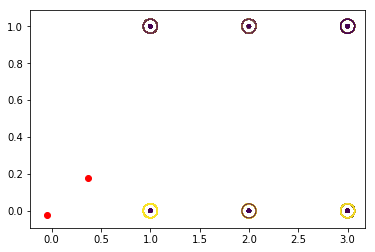

In [188]:
orig = plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y, s=200)
orig.set_facecolor('None') # Set color to None
plt.scatter(X.iloc[:,0], X.iloc[:,1], s=10, c=y_kmeans)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], c='red'
           );

In [189]:
# Check for reduced dimension
from sklearn.manifold import Isomap

In [190]:
iso = Isomap(n_components=2)
tc_reduced = iso.fit_transform(tc1.drop('sex', axis=1))

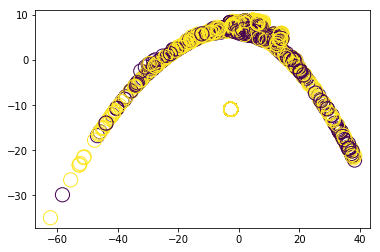

In [191]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None

3. Implement a search for the best number of clusters using the silhouette score from `sklearn.metrics`.
    * Set the parameters to 2,3,4,5,6 clusters.
    * Interpret the best results.
    * Try to find names for the clusters.

In [198]:
from sklearn.pipeline import Pipeline

In [199]:
X_complete = tc1.drop(['sex'], axis=1)

In [200]:
pipe = Pipeline([('cluster', KMeans())])

In [201]:
cluster__n_clusters = [2,3,4,5,6]

In [202]:
score = pd.DataFrame(columns=['clusters', 'silhouette_score', 'labels'])
for n_cluster in cluster__n_clusters:
    pipe = pipe.set_params(cluster__n_clusters = n_cluster)
    #pipe = pipe_no_iso.set_params(cluster__n_clusters =n_cluster)
    #pipe = KMeans(n_clusters=n_cluster)
    labels = pipe.fit_predict(X_complete)
    silhouette_avg = silhouette_score(X, labels)
    score = score.append({'clusters':n_cluster, 'silhouette_score': silhouette_avg, 'labels': labels}, ignore_index=True)

In [203]:
score.sort_values(by='silhouette_score')

,clusters,silhouette_score,labels
2,4,0.512949,"[0, 2, 2, 0, 0, 1, 1, 3, 1, 1, 1, 0, 0, 0, 1, ..."
3,5,0.519147,"[0, 2, 2, 0, 0, 4, 1, 4, 1, 1, 4, 3, 3, 0, 1, ..."
4,6,0.522038,"[1, 2, 2, 1, 1, 3, 5, 0, 3, 5, 3, 4, 1, 1, 5, ..."
1,3,0.546939,"[0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, ..."
0,2,0.587402,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, ..."


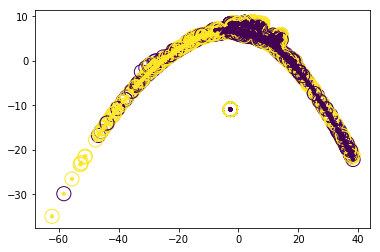

In [205]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0], tc_reduced[:,1], s=10, c=score.iloc[0,2]) # Cluster of 4

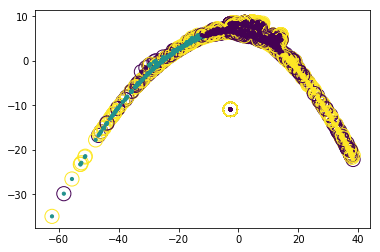

In [206]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0], tc_reduced[:,1], s=10, c=score.iloc[1,2]) # Cluster of 5

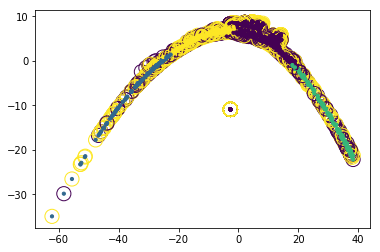

In [207]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0], tc_reduced[:,1], s=10, c=score.iloc[2,2]) # Cluster of 6

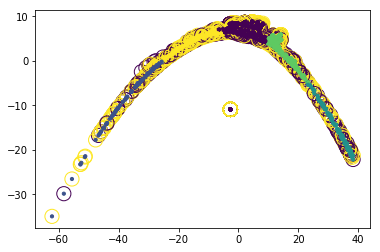

In [208]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0], tc_reduced[:,1], s=10, c=score.iloc[3,2]) # Cluster of 3

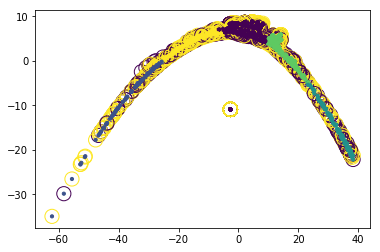

In [209]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0], tc_reduced[:,1], s=10, c=score.iloc[3,2]) # Cluster of 2

In [210]:
# With more clusters, there are more overlaps and making it have more misclassificaiton